In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
rcParams['figure.figsize'] = 15, 6

In [ ]:
data = pd.read_csv('/content/AirPassengers.csv')
print(data.head())
print('\n Data Types:',data.info())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB

 Data Types: None


Reading as datetime format:

In [ ]:
data['Month']=pd.to_datetime(data['Month'],infer_datetime_format=True)
data.set_index(['Month'],inplace=True)

In [ ]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
print(data.info())
data.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


RangeIndex(start=0, stop=144, step=1)

In [ ]:
ts = data['#Passengers']
ts.head(10)

0    112
1    118
2    132
3    129
4    121
5    135
6    148
7    148
8    136
9    119
Name: #Passengers, dtype: int64

# Checking for stationarity

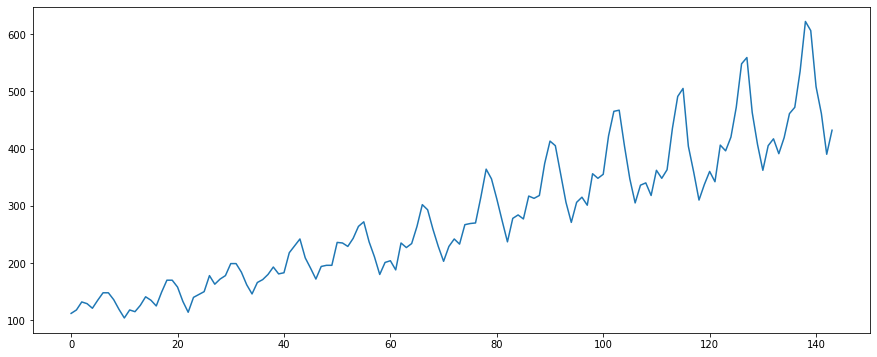

In [ ]:
plt.plot(ts)

This data is non-stationary. The mean is not constant (upward trend)

### Function for testing stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    rolmean=timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

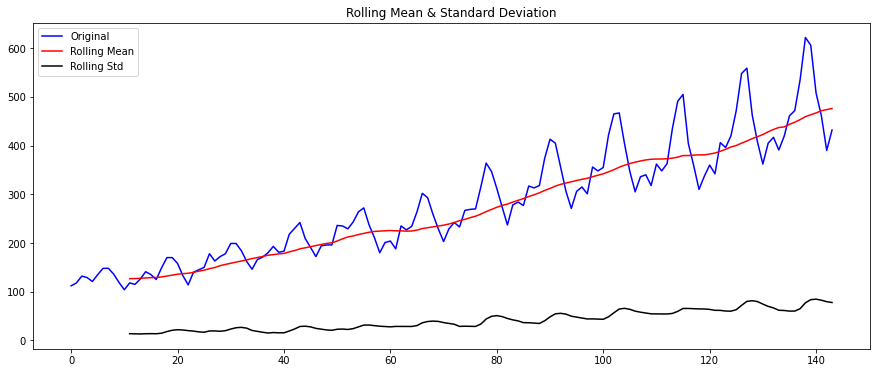

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
test_stationarity(ts)

The above clearly shows that both mean and standard deviation are changing. 
Even from Dickey-Fuller Test, p-value is 0.99 so we cannot reject the null hypothesis. the critical values are supposed to be more than T-statistic whcih is not the case

# Making Time series Stationary

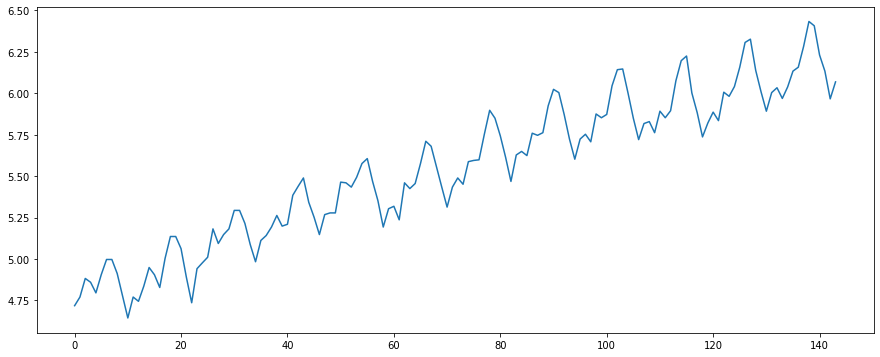

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Smoothing:

### Moving average

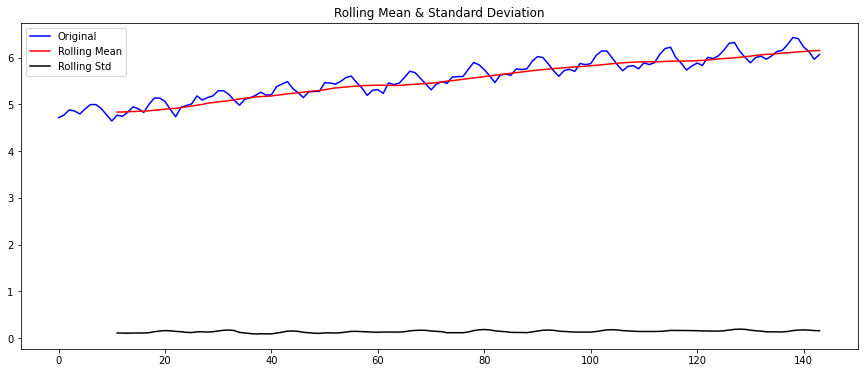

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
test_stationarity(ts_log)

Again not stationary as it's an upward trend

In [ ]:
moving_avg=ts_log.rolling(12).mean()
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff[7:15]

7          NaN
8          NaN
9          NaN
10         NaN
11   -0.065494
12   -0.093449
13   -0.007566
14    0.099416
Name: #Passengers, dtype: float64

In [ ]:
#dropping NAs
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

11   -0.065494
12   -0.093449
13   -0.007566
14    0.099416
15    0.052142
Name: #Passengers, dtype: float64

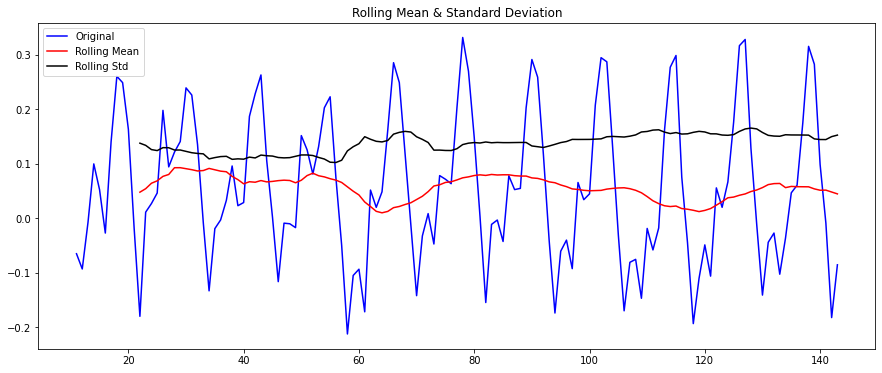

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [ ]:
test_stationarity(ts_log_moving_avg_diff)

p-value < 0.05, critical value > Test statistic which proves stationarity

### Exponentially Weighted Moving Average

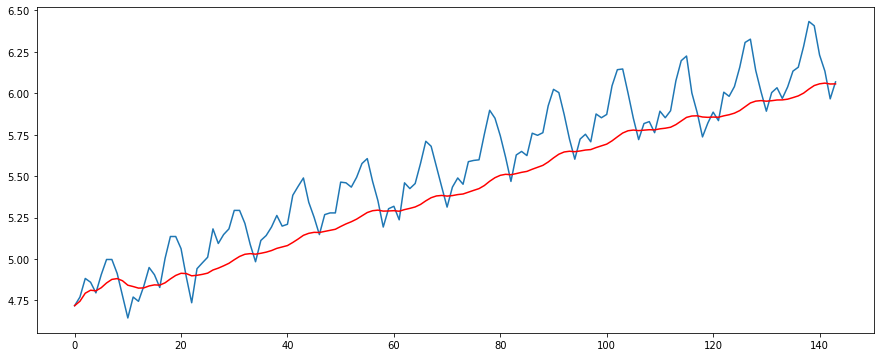

In [ ]:
expwighted_avg =ts_log.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

The upward trend is being captured by exp_weighted_avg. As time series is progressing we can see the wgtd mean is also progressing.

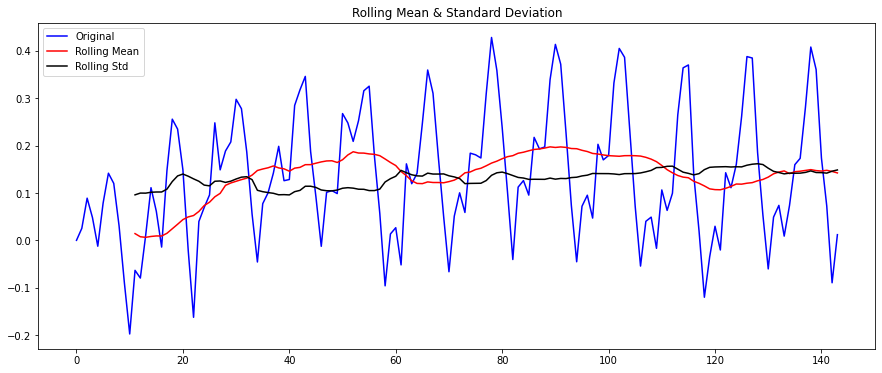

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

Std is quite flat and this doesn't have any trend ---- this time series is again stationary 

## Eliminating Trend and Seasonality

### Differencing:

In [ ]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

#ARIMA Auto regressive + Integration + Moving Average 

In [ ]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposition:

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Final Forecasting

### ACF & PACF Plots

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The values where it first hits off 0 are the corresponding P and Q

### AR Model:

In [ ]:
#MA model:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Greater the RSS, the more is the error

### MA Model

In [ ]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### ARIMA Model:

In [ ]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

### Convert to original scale:

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

In [ ]:
ts_log.index

In [ ]:
ts_log.iloc[0]

In [ ]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(ts.mean())
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))


In [ ]:
results_ARIMA.plot_predict(1,264)

In [ ]:
x=results_ARIMA.forecast(steps=120)
x[1:10]